# Yammer
Aineth Torres Ruiz
11/05/2020



**Use case:**
    - What's the cause of drop in user engagement or number of active users?
    - What recommendations can be made to reduce customer churn by identifying potential churn candidates beforehand, the causes of their churn and take proactive actions to make them stay?

**Findings:**
It seems that location, language, create_user & enter_email are causing drop in engagement

## Import key libraries

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
%matplotlib inline

# Part 1: Analyze users and events

## Read data

In [7]:
usersTable = 'https://raw.githubusercontent.com/Insight-DS-West/customerCliffDive/master/yammer_users.csv?token=ABFZSC3HBBWLXZUQBBYMWGS7WGJWU'
users = pd.read_csv(usersTable, error_bad_lines=False)
users.describe()

,user_id,company_id
count,19066.000000,19066.000000
mean,9532.500000,4602.923214
std,5504.024452,4363.468471
min,0.000000,1.000000
25%,4766.250000,109.000000
50%,9532.500000,3667.500000
75%,14298.750000,8431.750000
max,19065.000000,13198.000000


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       19066 non-null  float64
 1   created_at    19066 non-null  object 
 2   company_id    19066 non-null  float64
 3   language      19066 non-null  object 
 4   activated_at  9381 non-null   object 
 5   state         19066 non-null  object 
dtypes: float64(2), object(4)
memory usage: 893.8+ KB


In [9]:
eventsTable1 = 'https://raw.githubusercontent.com/Insight-DS-West/customerCliffDive/master/yammer_events_1.csv?token=ABFZSC37AJBBOB2TASQ4YBC7WGJ4W'
events1 = pd.read_csv(eventsTable1, error_bad_lines=False)
events1.describe()

,Unnamed: 0,user_id,user_type
count,170416.000000,170416.000000,154839.000000
mean,85207.500000,7165.336782,1.471464
std,49195.006074,5828.375747,0.734746
min,0.000000,4.000000,1.000000
25%,42603.750000,2458.000000,1.000000
50%,85207.500000,5224.000000,1.000000
75%,127811.250000,13022.000000,2.000000
max,170415.000000,19065.000000,3.000000


In [ ]:
events1.info()

In [ ]:
events1.occurred_at.max()
# May 1st, 2014 --> Aug 31st, 2014

In [10]:
eventsTable2 = 'https://raw.githubusercontent.com/Insight-DS-West/customerCliffDive/master/yammer_events_2.csv?token=ABFZSC3EU6W4BTNBHYLY6QC7WGJ7K'
events2 = pd.read_csv(eventsTable2, error_bad_lines=False)
events2.describe()

,Unnamed: 0,user_id,user_type
count,170416.000000,170416.000000,170416.000000
mean,255623.500000,12802.334734,1.549285
std,49195.006074,2795.548777,0.770667
min,170416.000000,7754.000000,1.000000
25%,213019.750000,10563.000000,1.000000
50%,255623.500000,12744.000000,1.000000
75%,298227.250000,14994.000000,2.000000
max,340831.000000,18815.000000,3.000000


In [ ]:
events2.occurred_at.min()
# May 1st, 2014 --> Aug 31st, 2014

In [41]:
events2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170416 entries, 0 to 170415
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   170416 non-null  int64  
 1   user_id      170416 non-null  float64
 2   occurred_at  170416 non-null  object 
 3   event_type   170416 non-null  object 
 4   event_name   170416 non-null  object 
 5   location     170416 non-null  object 
 6   device       170416 non-null  object 
 7   user_type    170416 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 10.4+ MB


In [44]:
#The two dfs seems equal let append them to create a single df
events = events1.append(events2, ignore_index = True)
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681664 entries, 0 to 681663
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   681664 non-null  int64  
 1   user_id      681664 non-null  float64
 2   occurred_at  681664 non-null  object 
 3   event_type   681664 non-null  object 
 4   event_name   681664 non-null  object 
 5   location     681664 non-null  object 
 6   device       681664 non-null  object 
 7   user_type    666087 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.6+ MB


##### Finding: It seems like events1 = events2, therefore, I will use only events1 from now on

##### Fix data formats

In [46]:
users['activated_at'] = pd.to_datetime(users['activated_at'])
users['act_date'] = pd.to_datetime(users['activated_at']).dt.date
users['created_at'] = pd.to_datetime(users['activated_at'])
users['cr_date'] = pd.to_datetime(users['activated_at']).dt.date
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

## Data cleansing and exploration

### Explore users

In [ ]:
users.head(10)

In [22]:
# Set to NaN, nan values (optional)
users['act_date'] = users['act_date'].replace({'nan':'NaN'})
# Count nulls in activation date - nonactive(pending) users
users.act_date.isin(['NaN']).sum(axis=0)

0

In [13]:
# Count users by state value
users.groupby("state")['state'].count()

state
active     9381
pending    9685
Name: state, dtype: int64

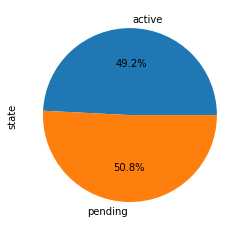

In [14]:
churn = users.groupby("state")['state'].count()
churn
churn.plot.pie(autopct="%.1f%%")

In [24]:

# NAN for testdf
nancolumns = ['act_date','state', 'cr_date']
for col in nancolumns:
    users[col].fillna('nan', inplace = True)

In [ ]:
(users
 .groupby(['date', 'state'])
 .size()
 .unstack()
 .plot.bar()
)

In [ ]:
rs = np.random.RandomState(365)
values = users['state'] == 'active'
dates = users['activated_at'].dt.month()
#pd.date_range(users['activated_at'])
data = pd.DataFrame(values, dates)
#data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

### Explore events

In [ ]:
events.head()
### Four categorical, one date,

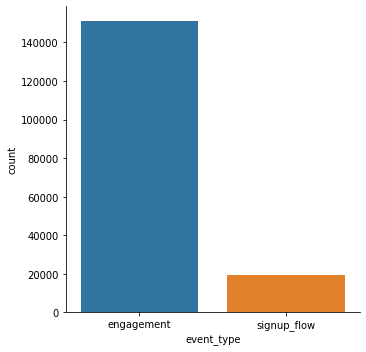

In [33]:
# How many types of events
sns.catplot(x='event_type', kind='count', data = events)

In [57]:
# Top events by type and users (%)
events['event_type'].value_counts(normalize=True).sort_values(ascending=False).head()

engagement     0.97175
signup_flow    0.02825
Name: event_type, dtype: float64

##### Event Names

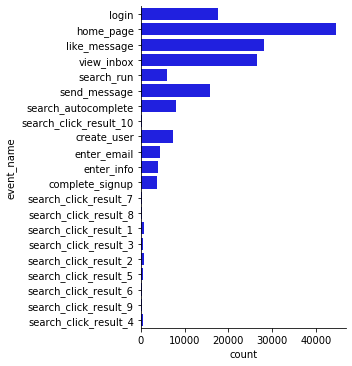

In [35]:
# How many types of events
g=sns.catplot(y='event_name', kind='count', color='b', data = events)
#g.set_xticklabels(rotation=30)

In [37]:
len(events['event_name'].unique())

21

In [31]:
# Top events by users (%)
events['event_name'].value_counts(normalize=True).sort_values(ascending=False).head()

home_page       0.261325
like_message    0.165430
view_inbox      0.155367
login           0.103952
send_message    0.092327
Name: event_name, dtype: float64

##### Locations

In [38]:
#How many type of locations
len(events['location'].unique())

47

In [30]:
# Top locations by users (%)
events['location'].value_counts(normalize=True).sort_values(ascending=False).head()

United States     0.280308
Japan             0.077945
Germany           0.065000
France            0.052736
United Kingdom    0.047548
Name: location, dtype: float64

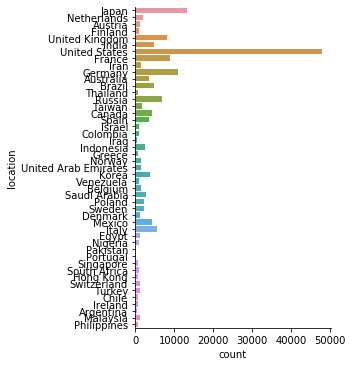

In [39]:
g=sns.catplot(y='location', kind='count', data=events)

##### Devices

In [40]:
# How many devices
len(events['device'].unique())

26

In [32]:
# Top devices by users (%)
events['device'].value_counts(normalize=True).sort_values(ascending=False).head()

macbook pro               0.176720
lenovo thinkpad           0.113346
macbook air               0.086524
iphone 5                  0.075809
dell inspiron notebook    0.057806
Name: device, dtype: float64

In [26]:
events.user_type.describe()

count    154839.000000
mean          1.471464
std           0.734746
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: user_type, dtype: float64

##### Users

In [27]:
user_type_dict = {
    1.0: 'User_1',
    2.0: 'User_2',
    3.0: 'User_3',
}

In [28]:
events['user_type'] = events1['user_type'].map(user_type_dict)
events['user_type'].head()

0    User_3
1    User_3
2    User_3
3    User_3
4    User_3
Name: user_type, dtype: object

In [29]:
events['user_type'].value_counts(normalize=True)

User_1    0.673868
User_2    0.180801
User_3    0.145332
Name: user_type, dtype: float64

##### Time series

In [50]:
#Add the week number into events table
events['week_number'] = events['occurred_at'].dt.week
#Count how many events per week
events_per_week = events.groupby('week_number').count().reset_index()
events_per_week

,week_number,Unnamed: 0,user_id,occurred_at,event_type,event_name,location,device,user_type
0,18,17419,17419,17419,17419,17419,17419,17419,17060
1,19,35272,35272,35272,35272,35272,35272,35272,34548
2,20,33395,33395,33395,33395,33395,33395,33395,32621
3,21,35709,35709,35709,35709,35709,35709,35709,34931
4,22,34681,34681,34681,34681,34681,34681,34681,33889
5,23,37807,37807,37807,37807,37807,37807,37807,36961
6,24,37444,37444,37444,37444,37444,37444,37444,36569
7,25,38918,38918,38918,38918,38918,38918,38918,38004
8,26,39914,39914,39914,39914,39914,39914,39914,39043
9,27,39548,39548,39548,39548,39548,39548,39548,38690


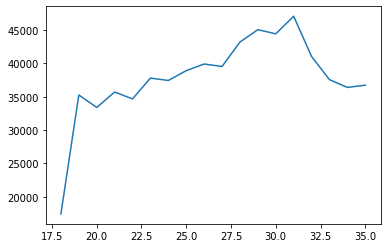

In [60]:
# take a look at the plot
plt.plot(events_per_week['week_number'], events_per_week['event_type'])

In [54]:
#Count how many events per week per user
events_per_week_per_user = events.groupby(['week_number', 'user_id']).count().reset_index()
events_per_week_per_user.head()

,week_number,user_id,Unnamed: 0,occurred_at,event_type,event_name,location,device,user_type
0,18,8.0,2,2,2,2,2,2,2
1,18,22.0,8,8,8,8,8,8,8
2,18,66.0,14,14,14,14,14,14,14
3,18,163.0,22,22,22,22,22,22,22
4,18,172.0,15,15,15,15,15,15,15


In [55]:
active_user_per_week = events_per_week_per_user.groupby('week_number')['user_id'].count().reset_index()
active_user_per_week

,week_number,user_id
0,18,791
1,19,1244
2,20,1270
3,21,1341
4,22,1293
5,23,1366
6,24,1434
7,25,1462
8,26,1443
9,27,1477


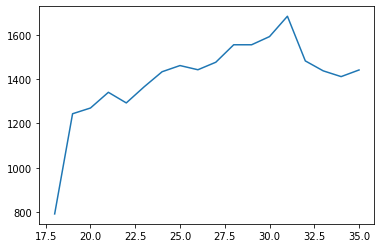

In [56]:
plt.plot(active_user_per_week['week_number'], active_user_per_week['user_id'])

### Emails

##### Actions

In [ ]:
#how many action in the emails
g=sns.catplot(x='action', kind='count', data=df_emails)
g.set_xticklabels(rotation=30)

## Merge users and events tables

In [75]:
# Merge tables
data = pd.merge(users,events,on='user_id',how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690970 entries, 0 to 690969
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       690970 non-null  float64       
 1   created_at    680366 non-null  datetime64[ns]
 2   company_id    690970 non-null  float64       
 3   language      690970 non-null  object        
 4   activated_at  680366 non-null  datetime64[ns]
 5   state         690970 non-null  object        
 6   act_date      680366 non-null  object        
 7   cr_date       680366 non-null  object        
 8   Unnamed: 0    681664 non-null  float64       
 9   occurred_at   681664 non-null  datetime64[ns]
 10  event_type    681664 non-null  object        
 11  event_name    681664 non-null  object        
 12  location      681664 non-null  object        
 13  device        681664 non-null  object        
 14  user_type     666087 non-null  object        
 15  week_number   681

#### Drop unnecessary vars 

In [76]:
# Drop unnecessary vars 
data.drop(['Unnamed: 0'], axis=1, inplace=True)


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690970 entries, 0 to 690969
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       690970 non-null  float64       
 1   created_at    680366 non-null  datetime64[ns]
 2   company_id    690970 non-null  float64       
 3   language      690970 non-null  object        
 4   activated_at  680366 non-null  datetime64[ns]
 5   state         690970 non-null  object        
 6   act_date      680366 non-null  object        
 7   cr_date       680366 non-null  object        
 8   occurred_at   681664 non-null  datetime64[ns]
 9   event_type    681664 non-null  object        
 10  event_name    681664 non-null  object        
 11  location      681664 non-null  object        
 12  device        681664 non-null  object        
 13  user_type     666087 non-null  object        
 14  week_number   681664 non-null  float64       
dtypes: datetime64[ns]

#### Format data

In [78]:
# Fromat dates
data['created_at'] = pd.to_datetime(data['created_at'])
data['occurred_at'] = pd.to_datetime(data['occurred_at'])
data['activated_at'] = pd.to_datetime(data['activated_at'])
data['company_id'] = data['company_id'].astype(str)
data['user_id'] = data['user_id'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690970 entries, 0 to 690969
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       690970 non-null  object        
 1   created_at    680366 non-null  datetime64[ns]
 2   company_id    690970 non-null  object        
 3   language      690970 non-null  object        
 4   activated_at  680366 non-null  datetime64[ns]
 5   state         690970 non-null  object        
 6   act_date      680366 non-null  object        
 7   cr_date       680366 non-null  object        
 8   occurred_at   681664 non-null  datetime64[ns]
 9   event_type    681664 non-null  object        
 10  event_name    681664 non-null  object        
 11  location      681664 non-null  object        
 12  device        681664 non-null  object        
 13  user_type     666087 non-null  object        
 14  week_number   681664 non-null  float64       
dtypes: datetime64[ns]

#### Check nulls 

In [79]:
# Check nulls
data.isnull().sum()

user_id             0
created_at      10604
company_id          0
language            0
activated_at    10604
state               0
act_date        10604
cr_date         10604
occurred_at      9306
event_type       9306
event_name       9306
location         9306
device           9306
user_type       24883
week_number      9306
dtype: int64

In [80]:
#Alternative, percentage  (%) of nulls
data.isnull().mean() * 100

user_id         0.000000
created_at      1.534654
company_id      0.000000
language        0.000000
activated_at    1.534654
state           0.000000
act_date        1.534654
cr_date         1.534654
occurred_at     1.346802
event_type      1.346802
event_name      1.346802
location        1.346802
device          1.346802
user_type       3.601169
week_number     1.346802
dtype: float64

In [ ]:
# Alternative way for percentage  (%) of nulls
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

In [81]:
data.dropna()
data.head()

,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,event_type,event_name,location,device,user_type,week_number
0,0.0,2013-01-01 21:01:07,5737.0,english,2013-01-01 21:01:07,active,2013-01-01,2013-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaT,28.0,english,NaT,pending,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaT,51.0,english,NaT,pending,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2013-01-01 18:42:02,2800.0,german,2013-01-01 18:42:02,active,2013-01-01,2013-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,User_3,20.0


##### Active users

In [82]:
#Count how many events per week per user
active_events_per_week_per_user = data[data['state'] == 'active']
active_events_per_week_per_user.head(5)

,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,event_type,event_name,location,device,user_type,week_number
0,0.0,2013-01-01 21:01:07,5737.0,english,2013-01-01 21:01:07,active,2013-01-01,2013-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2013-01-01 18:42:02,2800.0,german,2013-01-01 18:42:02,active,2013-01-01,2013-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,User_3,20.0
5,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:32:10,engagement,home_page,India,lenovo thinkpad,User_3,20.0
6,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:32:26,engagement,search_autocomplete,India,lenovo thinkpad,User_3,20.0


In [83]:
active_events_per_week_per_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680366 entries, 0 to 690967
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       680366 non-null  object        
 1   created_at    680366 non-null  datetime64[ns]
 2   company_id    680366 non-null  object        
 3   language      680366 non-null  object        
 4   activated_at  680366 non-null  datetime64[ns]
 5   state         680366 non-null  object        
 6   act_date      680366 non-null  object        
 7   cr_date       680366 non-null  object        
 8   occurred_at   677127 non-null  datetime64[ns]
 9   event_type    677127 non-null  object        
 10  event_name    677127 non-null  object        
 11  location      677127 non-null  object        
 12  device        677127 non-null  object        
 13  user_type     666087 non-null  object        
 14  week_number   677127 non-null  float64       
dtypes: datetime64[ns]

In [84]:
active_events_per_week_per_user.groupby(['week_number', 'user_id']).agg(
    count_rows=pd.NamedAgg(column='event_type', aggfunc="count")).reset_index()

,week_number,user_id,count_rows
0,18.0,10033.0,36
1,18.0,10075.0,9
2,18.0,10094.0,36
3,18.0,10097.0,15
4,18.0,10099.0,21
...,...,...,...
21663,35.0,9895.0,33
21664,35.0,9949.0,27
21665,35.0,9954.0,27
21666,35.0,9956.0,78


In [85]:
active_user_per_week = active_events_per_week_per_user.groupby('week_number')['user_id'].count().reset_index()
active_user_per_week

,week_number,user_id
0,18.0,17303
1,19.0,35028
2,20.0,33179
3,21.0,35462
4,22.0,34447
5,23.0,37552
6,24.0,37163
7,25.0,38670
8,26.0,39673
9,27.0,39287


In [86]:
active_user_per_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   week_number  18 non-null     float64
 1   user_id      18 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 416.0 bytes


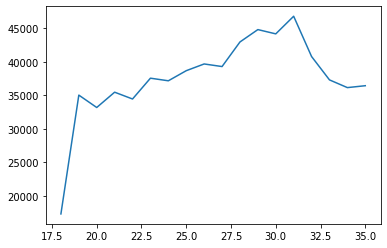

In [87]:
plt.plot(active_user_per_week['week_number'], active_user_per_week['user_id'])

##### Events per device

In [90]:
events_device = active_events_per_week_per_user[ (active_events_per_week_per_user.event_type=='engagement') & (active_events_per_week_per_user.event_name == 'login')]
events_device.head(2)

,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,event_type,event_name,location,device,user_type,week_number
4,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,User_3,20.0
8,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-24 11:39:53,engagement,login,India,samsung galaxy s4,User_3,21.0


In [91]:
events_device['device'].unique()

array(['lenovo thinkpad', 'samsung galaxy s4', 'dell inspiron desktop',
       'nexus 7', 'macbook pro', 'iphone 5s', 'iphone 4s', 'ipad air',
       'iphone 5', 'kindle fire', 'asus chromebook', 'nexus 5',
       'hp pavilion desktop', 'macbook air', 'acer aspire notebook',
       'htc one', 'mac mini', 'amazon fire phone', 'acer aspire desktop',
       'dell inspiron notebook', 'nokia lumia 635', 'ipad mini',
       'nexus 10', 'windows surface', 'samsumg galaxy tablet',
       'samsung galaxy note'], dtype=object)

In [93]:
#Define vectors for device type
phone=['iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nokia lumia 635',
       'htc one','samsung galaxy note','amazon fire phone']
computer=['macbook pro','lenovo thinkpad','macbook air','dell inspiron notebook',
          'asus chromebook','dell inspiron desktop','acer aspire notebook','hp pavilion desktop','acer aspire desktop','mac mini']
tablet=['ipad air','nexus 7','ipad mini','nexus 10','kindle fire','windows surface',
        'samsumg galaxy tablet']
# Create a list then add to df 
device_type_list=[]
for element in events_device['device']:
    if element in phone:
        device_type_list.append('phone')
    if element in computer:
        device_type_list.append('computer')
    if element in tablet:
        device_type_list.append('tablet')

In [94]:
len(device_type_list)

80400

In [95]:
# Add the list to the df
events_device['device_type'] = device_type_list

In [96]:
events_device['device_type'].value_counts()

computer    46365
phone       25017
tablet       9018
Name: device_type, dtype: int64

In [97]:
events_device.head(2)

,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,event_type,event_name,location,device,user_type,week_number,device_type
4,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,User_3,20.0,computer
8,4.0,2013-01-01 14:39:05,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,2013-01-01,2014-05-24 11:39:53,engagement,login,India,samsung galaxy s4,User_3,21.0,phone


In [98]:
#Select user connected by certain device using a function
def check_by_device(df, dev_type):
    # Slice df
    device_active = df[df['device_type'] == dev_type]
    #Count how many events per week per user
    events_per_week_per_user = device_active.groupby(['week_number', 'user_id']).count().reset_index()
    # count again
    active_user_per_week = events_per_week_per_user.groupby('week_number')['user_id'].count().reset_index()
    # Plot
    plt.plot(active_user_per_week['week_number'], active_user_per_week['user_id'])
    plt.grid(True)
    plt.show()

In [102]:
# Check values for users connecting by computer
device_active = events_device[events_device['device_type'] == 'computer']
events_per_week_per_user = device_active.groupby(['week_number', 'user_id']).count().reset_index()
events_per_week_per_user. head(2)

,week_number,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,event_type,event_name,location,device,user_type,device_type
0,18.0,10033.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1,18.0,10097.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [103]:
active_user_per_week = events_per_week_per_user.groupby('week_number')['user_id'].count().reset_index()
active_user_per_week.head(2)

,week_number,user_id
0,18.0,415
1,19.0,712


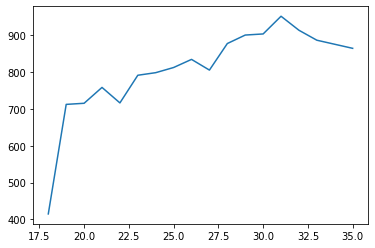

In [104]:
plt.plot(active_user_per_week['week_number'], active_user_per_week['user_id'])

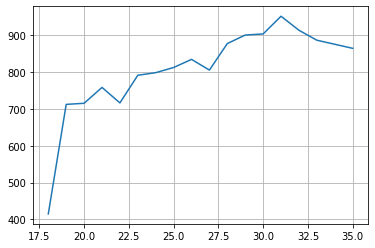

In [105]:
check_by_device(events_device, 'computer')

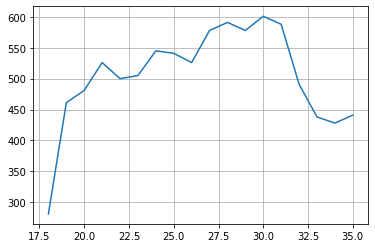

In [106]:
check_by_device(events_device, 'phone')

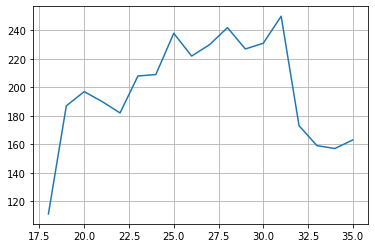

In [107]:
check_by_device(events_device, 'tablet')

## Data prep

##### Get dummies

In [ ]:
# Replace state with integers
#data['state_int'] = data['state'].replace({'active':'1', 'pending':'-1'})
data = data.reset_index()
data.head()

In [ ]:
#get_dummies(data['language'])
mycols = ["state", "language", "event_type", "event_name", "location", "device", "user_type"]
dummies = pd.get_dummies(data[mycols])
dummies.columns

#### Define features & targets

In [ ]:
y = dummies["state_active"].values  #Target
X = dummies.drop(labels = ["state_active", "state_pending"],axis = 1)  #Features

#### Split dataset

In [ ]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

## Log regression

In [ ]:
# Import necessary model
from sklearn.linear_model import LogisticRegression
np.random.seed(0)   # setting random seed for reproducibility

# Create instance of Logistic Regression object
model = LogisticRegression(C=2, solver='liblinear')

# Train logistic regression model
result = model.fit(X_train, y_train)
result

In [ ]:
# Store predictions in new column in DataFrame
dummies['predictions_logreg'] = model.predict(X)

# Create confusion matrix
conf_matrix = pd.crosstab(dummies['predictions_logreg'], dummies['state_active'])
conf_matrix


In [ ]:
# Calculate accuracy from confusion matrix
accuracy = (conf_matrix.iloc[0, 0] + conf_matrix.iloc[1, 1]) / data.shape[0]

print(f"The model's accuracy was {(accuracy * 100):.4f}%")

In [ ]:
## Predict on test data & obtain accuracy

from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

## Question 1
What's the cause of drop in user engagement or number of active users?

In [ ]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
 index=X.columns.values)
weights.sort_values(ascending = False). head(20) ## Users with these values are very LIKELY to remain active 

In [ ]:
weights.sort_values(ascending = True).head(20) ## Users with these values are very UNLIKELY to remain active 

In [ ]:
drop_causes = weights.sort_values(ascending = True)
drop_causes.sort_values(ascending = True).head(20) 

##### It seems that location, language, create_user & enter_email are causing drop in engagement. Especially, create_user seems to be causing the more problem. Fortunately, we have  email records, which should give us more hints about the sources of drop.

# Part 2: Analyze email events

## Explore email events [in progress]

In [108]:
emailEventsTable = 'https://raw.githubusercontent.com/Insight-DS-West/customerCliffDive/master/yammer_emails.csv?token=ABFZSCYQI2VAQEFG62PJRSC7WGRAC'
emailEvents = pd.read_csv(emailEventsTable, error_bad_lines=False)
emailEvents.describe()

,user_id,user_type
count,90389.000000,90389.000000
mean,8635.558187,2.097988
std,4957.734547,0.848892
min,0.000000,1.000000
25%,4426.000000,1.000000
50%,8631.000000,2.000000
75%,12670.000000,3.000000
max,19001.000000,3.000000


In [110]:
emailEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      90389 non-null  float64
 1   occurred_at  90389 non-null  object 
 2   action       90389 non-null  object 
 3   user_type    90389 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.8+ MB


In [112]:
emailEvents['action'].unique()

array(['sent_weekly_digest', 'email_open', 'email_clickthrough',
       'sent_reengagement_email'], dtype=object)

In [113]:
# Merge with df_user
df_user_and_emails = users.merge(emailEvents, how='left', on='user_id')
df_user_and_emails.head(2)

,user_id,created_at,company_id,language,activated_at,state,act_date,cr_date,occurred_at,action,user_type
0,0.0,2013-01-01 21:01:07,5737.0,english,2013-01-01 21:01:07,active,2013-01-01,2013-01-01,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2013-01-01 21:01:07,5737.0,english,2013-01-01 21:01:07,active,2013-01-01,2013-01-01,2014-05-13 09:30:00,sent_weekly_digest,1.0


In [115]:
#Add the week number into events table
df_user_and_emails['occurred_at'] = pd.to_datetime(data['occurred_at'])
df_user_and_emails['week_number'] = df_user_and_emails['occurred_at'].dt.week

In [116]:
# define a new function to check according action...
def check_by_email(df, action_type):
    # Slice df
    eng_by_action = df[df['action'] == action_type]
    #Count how many events per week per user
    events_per_week_per_user = eng_by_action.groupby(['week_number', 'user_id']).count().reset_index()
    # count again
    active_user_per_week = events_per_week_per_user.groupby('week_number')['user_id'].count().reset_index()
    # Plot
    plt.plot(active_user_per_week['week_number'], active_user_per_week['user_id'])
    plt.grid(True)
    plt.show()

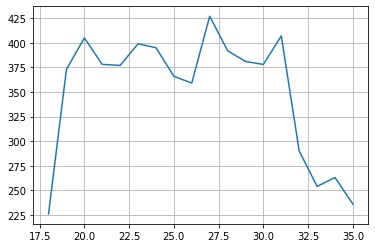

In [117]:
check_by_email(df_user_and_emails, 'email_clickthrough')

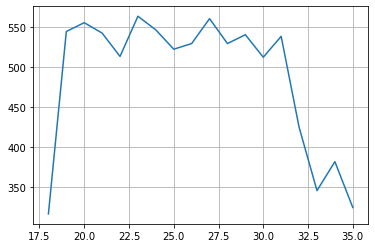

In [118]:
check_by_email(df_user_and_emails, 'email_open')

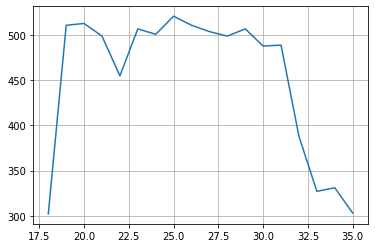

In [119]:
check_by_email(df_user_and_emails, 'sent_weekly_digest')

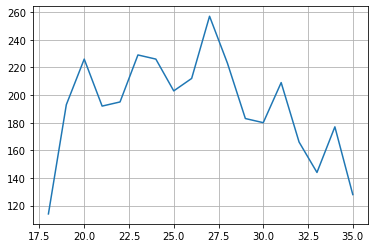

In [120]:
check_by_email(df_user_and_emails, 'sent_reengagement_email')